In [19]:
import keras
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [20]:
data = pd.read_csv('voc.csv')
data = data.drop('Unnamed: 0', 1)
data['File_Path'] = './VOCdevkit2007/VOC2007/JPEGImages/' + data['Frame']
#data = data[(data['label'] == 0)].reset_index()
print(data.head())

        Frame   xmin   xmax   ymin   ymax  label  type  \
0  003815.jpg  188.0  433.0  108.0  213.0    0.0  test   
1  003815.jpg  231.0  259.0    1.0   54.0    1.0  test   
2  003815.jpg  186.0  219.0    1.0   54.0    1.0  test   
3  003815.jpg  242.0  274.0   11.0   95.0    1.0  test   
4  003815.jpg  288.0  333.0  125.0  149.0    1.0  test   

                                       File_Path  
0  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
1  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
2  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
3  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
4  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  


In [21]:
def csv2bbox(bbox):
    gta = np.zeros((len(bb_boxes), 4))
    #print(gta.shape)
    #bbox groundtruth before bbox_encode
    for i in range(len(bb_boxes)):
        gta[i, 0] = int(bb_boxes.iloc[i]['xmin'])
        gta[i, 1] = int(bb_boxes.iloc[i]['ymin'])
        gta[i, 2] = int(bb_boxes.iloc[i]['xmax'])
        gta[i, 3] = int(bb_boxes.iloc[i]['ymax'])
    return gta

5


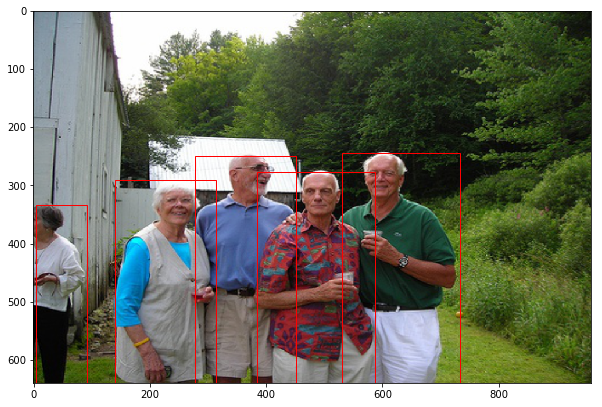

In [57]:
#load img and bbox
import batch_generate
i_line = np.random.randint(len(data))
name_str, img, bb_boxes = batch_generate.get_img_by_name(data, i_line, size = (960, 640))
gta = csv2bbox(bb_boxes)
plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
print(len(gta))
for i in range(len(gta)):
    currentAxis.add_patch(plt.Rectangle((gta[i,0], gta[i,1]), gta[i,2]-gta[i,0], gta[i,3]-gta[i,1], fill=False, edgecolor= 'r', linewidth=1))

In [58]:
import netarch
import tensorflow as tf
import keras
from keras import backend as K
from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
input_shape_img = (None, None, 3)
img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(300, 4))
# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = netarch.base_net(img_input, trainable=False)
# define the RPN, built on the base layers
num_anchors = 9
rpn = netarch.rpn(shared_layers, num_anchors)
model_rpn = Model(img_input, rpn[:2])
model_rpn.load_weights('rpn.h5', by_name=True)

In [59]:
img_channel_mean = [103.939, 116.779, 123.68]
img_scaling_factor = 1.0
x_img = img.astype(np.float32)
x_img[:, :, 0] -= img_channel_mean[0]
x_img[:, :, 1] -= img_channel_mean[1]
x_img[:, :, 2] -= img_channel_mean[2]
x_img /= img_scaling_factor
bat_img = np.expand_dims(x_img, axis=0)
P_rpn = model_rpn.predict_on_batch(bat_img)

In [60]:
#print(P_rpn[0])
print(P_rpn[0].shape)

(1, 40, 60, 9)


In [61]:
#print(P_rpn[1])
print(P_rpn[1].shape)

(1, 40, 60, 36)


In [62]:
import utils
boxes, scores = utils.propose_cpu(P_rpn[1], P_rpn[0], maximum = 50)

> 0.7  scores 13


In [63]:
print(boxes)

[[[318 183 818 555]
  [321  92 827 460]
  [189 248 849 677]
  [313 277 810 649]
  [119 195 828 629]
  [179 131 907 548]
  [ 74 133 799 574]
  [ 84  45 785 472]
  [ 23 219 763 677]
  [256  83 943 493]
  [ -4 109 727 526]
  [222 178 973 635]
  [197  43 866 441]
  [158 111 519 523]
  [476  76 835 489]
  [477 176 838 590]
  [228 192 443 380]
  [547 160 764 349]
  [227 240 441 428]
  [422 123 785 540]
  [109 152 472 575]
  [549 254 762 442]
  [548 208 762 396]
  [227 144 444 330]
  [229 288 444 476]
  [230  49 446 235]
  [541 398 761 585]
  [225 381 443 568]
  [104  54 470 476]
  [546 111 764 298]
  [546  64 766 250]
  [225  95 445 282]
  [228 430 446 618]
  [552 302 766 489]
  [546 349 764 537]
  [229 333 443 521]
  [553 445 771 632]
  [392 193 759 614]
  [141 120 197 190]
  [325 169 702 589]
  [201 141 591 564]
  [460 135 518 206]
  [206  52 592 475]
  [254 161 642 599]
  [458  96 515 163]
  [157 122 214 192]
  [369  71 752 496]
  [268  77 650 491]
  [129 124 188 191]
  [477  94 534 162]]

(50, 4)


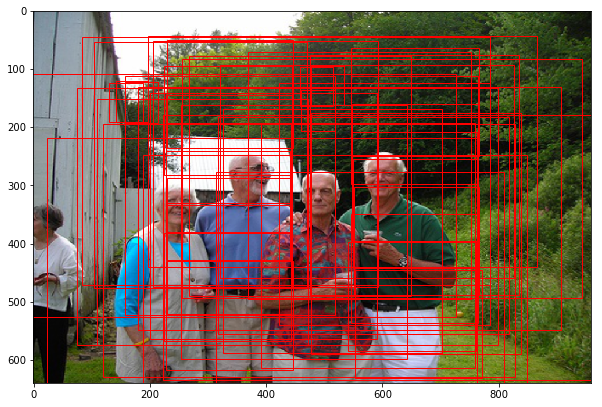

In [64]:
plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
box = boxes[0]
print(box.shape)
for i in range(len(box)):
    currentAxis.add_patch(plt.Rectangle((box[i,0], box[i,1]), box[i,2]-box[i,0], box[i,3]-box[i,1], fill=False, edgecolor= 'r', linewidth=1))

In [65]:
import losses
input_shape_img = (None, None, 3)
img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(300, 4))
# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = netarch.base_net(img_input, trainable=False)
# define the RPN, built on the base layers
num_anchors = 9
rpn = netarch.rpn(shared_layers, num_anchors)
model_rpn = Model(img_input, rpn[:2])
#Single training On single images
model_rpn.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels.h5', by_name=True)
optimizer = Adam(lr=1e-5)
model_rpn.compile(optimizer=optimizer, loss=[losses.rpn_classification(num_anchors), losses.rpn_regression(num_anchors)])

In [66]:
y_rpn_cls,y_rpn_regr = batch_generate.label_generate(img, gta)

number of postive samples 17
number of negative samples 239


In [67]:
X = bat_img
Y = [y_rpn_cls,y_rpn_regr]
loss_rpn = model_rpn.train_on_batch(X, Y)
P_rpn = model_rpn.predict_on_batch(X)

> 0.7  scores 0
(50, 4)


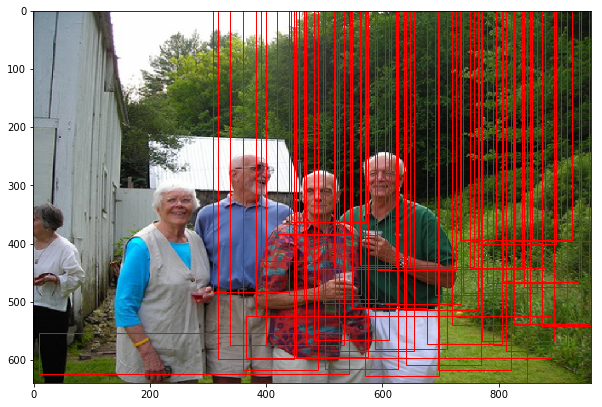

In [68]:
boxes, scores = utils.propose_cpu(P_rpn[1], P_rpn[0], maximum = 50)
plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
box = boxes[0]
print(box.shape)
for i in range(len(box)):
    currentAxis.add_patch(plt.Rectangle((box[i,0], box[i,1]), box[i,2]-box[i,0], box[i,3]-box[i,1], fill=False, edgecolor= 'r', linewidth=1))

In [69]:
loss_rpn = model_rpn.train_on_batch(X, Y)
P_rpn = model_rpn.predict_on_batch(X)

> 0.7  scores 0
(50, 4)


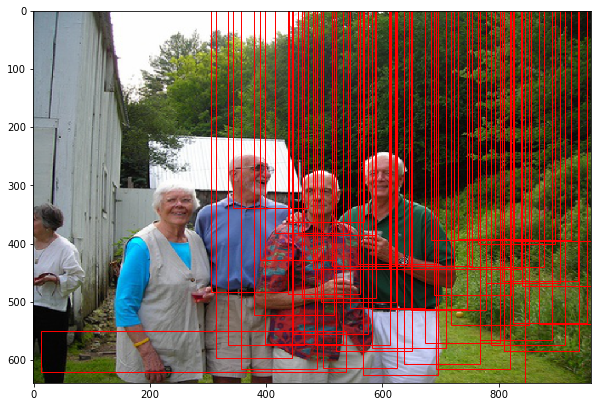

In [70]:
boxes, scores = utils.propose_cpu(P_rpn[1], P_rpn[0], maximum = 50)
plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
box = boxes[0]
print(box.shape)
for i in range(len(box)):
    currentAxis.add_patch(plt.Rectangle((box[i,0], box[i,1]), box[i,2]-box[i,0], box[i,3]-box[i,1], fill=False, edgecolor= 'r', linewidth=1))

iter 0, loss [1.2623751, 0.66573954, 0.59663552]
iter 1, loss [1.2523576, 0.66303283, 0.58932477]
iter 2, loss [1.242063, 0.66025352, 0.58180946]
iter 3, loss [1.2316096, 0.65743399, 0.57417554]
iter 4, loss [1.2210639, 0.65459239, 0.56647152]
iter 5, loss [1.2104659, 0.65173978, 0.55872619]
iter 6, loss [1.1998429, 0.64888376, 0.55095917]
iter 7, loss [1.1892126, 0.64602906, 0.54318345]
iter 8, loss [1.1785898, 0.64318019, 0.53540963]
iter 9, loss [1.167985, 0.64033955, 0.52764535]
iter 10, loss [1.1574061, 0.63750958, 0.51989657]
iter 11, loss [1.1468588, 0.63469195, 0.51216686]
iter 12, loss [1.1363481, 0.63188839, 0.50445974]
iter 13, loss [1.1258775, 0.62909997, 0.49677756]
iter 14, loss [1.1154497, 0.62632757, 0.48912209]
iter 15, loss [1.1050673, 0.62357229, 0.48149502]
iter 16, loss [1.0947341, 0.62083471, 0.47389936]
iter 17, loss [1.0844539, 0.61811548, 0.46633843]
iter 18, loss [1.0742297, 0.6154151, 0.45881465]
iter 19, loss [1.0640633, 0.6127342, 0.45132914]
iter 20, loss 

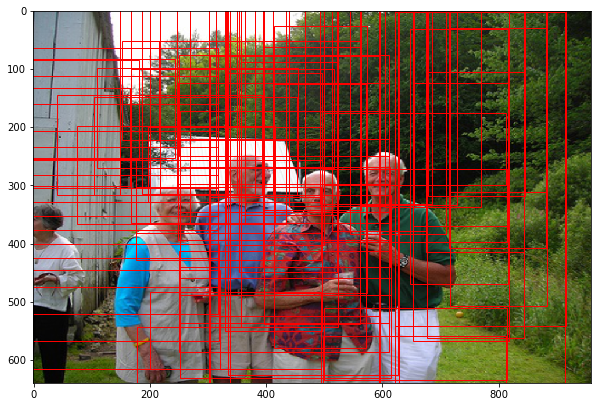

In [71]:
#100 training
for i in range(100):
    loss_rpn = model_rpn.train_on_batch(X, Y)
    P_rpn = model_rpn.predict_on_batch(X)
    print('iter {0}, loss {1}'.format(i, loss_rpn))
boxes, scores = utils.propose_cpu(P_rpn[1], P_rpn[0], maximum = 80)

plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
box = boxes[0]
print(box.shape)
for i in range(len(box)):
    currentAxis.add_patch(plt.Rectangle((box[i,0], box[i,1]), box[i,2]-box[i,0], box[i,3]-box[i,1], fill=False, edgecolor= 'r', linewidth=1))